In [ ]:
# !pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 36.7 MB/s 


In [ ]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings; warnings.filterwarnings('ignore')
import cv2
# import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from pylab import rcParams
rcParams['figure.figsize'] = 20,5

In [ ]:
!gdown --id 1diztKyKFfhINpY-8R_KB84kV8akW2NjD

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1diztKyKFfhINpY-8R_KB84kV8akW2NjD
To: /content/test_train_val.zip
100% 480M/480M [00:02<00:00, 232MB/s]


In [ ]:
!unzip -qq test_train_val.zip

replace test_train_val/test_meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
with open('test_train_val/train_meta.csv') as f:
  train_df= pd.read_csv(f)
with open('test_train_val/train_signal.csv') as f:
  train_signal = pd.read_csv(f)

with open('test_train_val/valid_meta.csv') as f:
  valid_df= pd.read_csv(f)
with open('test_train_val/valid_signal.csv') as f:
  valid_signal = pd.read_csv(f)

with open('test_train_val/test_meta.csv') as f:
  test_df= pd.read_csv(f)
with open('test_train_val/test_signal.csv') as f:
  test_signal = pd.read_csv(f)

print(train_df.shape)

train_df

(17441, 37)


,ecg_id,age,sex,height,weight,nurse,site,device,NORM,MI,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
0,1,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,3
1,2,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,2
2,3,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,5
3,4,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,3
4,5,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,21832,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,7
17437,21833,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,7
17438,21834,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,1,0,...,0,0,0,0,0,0,0,0,0,4
17439,21835,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
class PTBXLDatasetPreprocesser():
    def __init__(self):
        pass
    
    def save(self, filename):
        data = {
            'superclass_cols': self.superclass_cols,
            'subclass_cols': self.subclass_cols,
            'meta_num_cols': self.meta_num_cols,
            'meta_num_means': self.meta_num_means,
            'min_max_scaler': self.min_max_scaler,
            'meta_cat_cols': self.meta_cat_cols,
            'cat_lablers': self.cat_lablers,
            'bclass_cols': self.bclass_cols,
            
        }
        pd.to_pickle(data, filename)
        
    def load(self, filename):
        data = pd.read_pickle(filename)
        self.min_max_scaler = data['min_max_scaler']
        self.cat_lablers = data['cat_lablers']
        #self.binary_lablers = data['binary_lablers']
        
    def fit(self, x, y):
        x = x.copy()
        y = y.copy()
        
        self.superclass_cols = [ 'MI', 'STTC', 'CD', 'HYP']
        
        self.subclass_cols = [col for col in y.columns if 'sub_' in col]

        self.bclass_cols = ['NORM']
        
        self.meta_num_cols = ['age', 'height', 'weight']
        self.meta_num_means = []
        for col in self.meta_num_cols:
            print(col, y[col].mean())
            y[col] = y[col].fillna(y[col].mean())
            self.meta_num_means += [y[col].mean()]
            
        self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        self.meta_cat_cols = ['sex'] #, 'nurse', 'device']
        self.cat_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_cat_cols]
        return self

        #self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        #self.meta_binary_cols = ['NORM'] 
        #self.binary_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_binary_cols]
        #return self
    
    def transform(self, x, y):
        
        channel_cols = x.columns.tolist()[1:]
        
        ret = []
        x = x[channel_cols].values.reshape(-1, 1000, 12)
        print(x.shape)
        ret += [x] # signal
        
        y_ = y.copy()
        
        for i, col in enumerate(self.meta_num_cols):
            y_[col] = y_[col].fillna(self.meta_num_means[i])
        y_[self.meta_num_cols] = self.min_max_scaler.transform(y_[self.meta_num_cols])
        y_[self.meta_num_cols] = np.clip(y_[self.meta_num_cols], 0., 1.) # prevent extreme value far from train set
        
        ret += [y_[self.meta_num_cols]] # meta num features
        
        for i, col in enumerate(self.meta_cat_cols):
            y_[col] = y_[col].fillna('none').astype(str)
            y_[col] = self.cat_lablers[i].transform(y_[col]) 
        
        ret += [y_[self.meta_cat_cols]] # meta cat features

        #for i, col in enumerate(self.meta_binary_cols):
           # y_[col] = y_[col].fillna('none').astype(str)
           # y_[col] = self.binary_lablers[i].transform(y_[col]) 
        
        #ret += [y_[self.meta_binary_cols]] # binary class target
        
        if np.isin(self.superclass_cols, y.columns).sum() == len(self.superclass_cols):
            ret += [y[self.superclass_cols].fillna(0).astype(int)] # superclass targets
        
        if np.isin(self.subclass_cols, y.columns).sum() == len(self.subclass_cols):
            ret += [y[self.subclass_cols].fillna(0).astype(int)] # subclass targets

        if np.isin(self.bclass_cols, y.columns).sum() == len(self.bclass_cols):
            ret += [y[self.bclass_cols].fillna(0).astype(int)]
        
        return ret

In [ ]:
data_preprocessor = PTBXLDatasetPreprocesser()
data_preprocessor.fit(train_signal, train_df)
train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass, train_subclass, train_bclass = data_preprocessor.transform(train_signal, train_df)
valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass, valid_subclass, valid_bclass = data_preprocessor.transform(valid_signal, valid_df)
test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass, test_bclass = data_preprocessor.transform(test_signal, test_df)

print(train_signal.shape)
print(valid_meta_num_feats.isna().sum(), valid_meta_cat_feats.isna().sum(), valid_superclass.isna().sum(), valid_subclass.isna().sum(), valid_bclass.isna().sum())

display(train_meta_num_feats)
display(train_meta_cat_feats)
display(train_superclass)
display(train_subclass)
display(train_bclass)

age 59.63709074169975
height 166.68908469699693
weight 70.69599447513812
(17441, 1000, 12)
(2193, 1000, 12)
(2203, 1000, 12)
(17441, 1000, 12)
age       0
height    0
weight    0
dtype: int64 sex    0
dtype: int64 MI      0
STTC    0
CD      0
HYP     0
dtype: int64 sub_NORM         0
sub_IMI          0
sub_STTC         0
sub_NST_         0
sub_LVH          0
sub_LAFB/LPFB    0
sub_RVH          0
sub_RAO/RAE      0
sub_IRBBB        0
sub_IVCD         0
sub_LMI          0
sub_AMI          0
sub__AVB         0
sub_ISCA         0
sub_ISC_         0
sub_SEHYP        0
sub_ISCI         0
sub_CRBBB        0
sub_CLBBB        0
sub_LAO/LAE      0
sub_ILBBB        0
sub_WPW          0
sub_PMI          0
dtype: int64 NORM    0
dtype: int64


,age,height,weight
0,0.580645,0.791572,0.282927
1,0.182796,0.791572,0.317073
2,0.376344,0.791572,0.312195
3,0.236559,0.791572,0.375610
4,0.182796,0.791572,0.317073
...,...,...,...
17436,0.655914,0.791572,0.320468
17437,0.698925,0.791572,0.320468
17438,0.978495,0.791572,0.320468
17439,0.612903,0.791572,0.320468


,sex
0,1
1,0
2,1
3,0
4,1
...,...
17436,0
17437,1
17438,0
17439,1


,MI,STTC,CD,HYP
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
17436,0,0,1,0
17437,0,1,0,0
17438,0,0,0,0
17439,0,1,0,0


,sub_NORM,sub_IMI,sub_STTC,sub_NST_,sub_LVH,sub_LAFB/LPFB,sub_RVH,sub_RAO/RAE,sub_IRBBB,sub_IVCD,...,sub_ISCA,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17437,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17438,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17439,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,NORM
0,1
1,1
2,1
3,1
4,1
...,...
17436,0
17437,0
17438,1
17439,0


In [ ]:
signal=np.array(train_signal)
target=np.array(train_bclass)

v_signal=np.array(valid_signal)
v_target=np.array(valid_bclass)

t_signal=np.array(test_signal)
t_target=np.array(test_bclass)

In [ ]:
full_signal= np.vstack((signal,v_signal,t_signal))
full_signal.shape

(21837, 1000, 12)

In [ ]:
full_target= np.vstack((target,v_target,t_target))
full_target.shape

(21837, 1)

In [ ]:
# v_signal.shape

In [ ]:
#newv_signal=v_signal.reshape(2193,10,100,12)

In [ ]:
# v_target=np.array(valid_bclass)
# v_target.shape

In [ ]:
# t_signal=np.array(test_signal)
# t_target=np.array(test_bclass)

In [ ]:
# full_signal= np.vstack((signal,v_signal,t_signal))
# full_signal.shape

(21837, 1000, 12)

In [ ]:
# full_target= np.vstack((target,v_target,t_target))
# full_target.shape

(21837, 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(full_signal, full_target, test_size=0.15, random_state=25)

In [ ]:
# !pip install ecg-plot
#import physionet_challenge_utility_script as pc
# import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
#from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional, ConvLSTM1D
from keras.models import Sequential, Model
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.layers import concatenate, Flatten
from scipy import optimize
from scipy.io import loadmat
import os
%load_ext autoreload
%autoreload
%reload_ext autoreload

In [ ]:
vot = []
from keras.layers import LeakyReLU

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', mode='max', verbose=1, patience=12
    )

**Binary Classification on ECG ataset**

**ANN MODEL**

In [ ]:
# ann_model = Sequential()
# ann_model.add(Dense(50, activation='relu', input_shape=(1000,12)))
# ann_model.add(Dense(50, activation='relu'))
# ann_model.add(Dense(50, activation='relu'))
# ann_model.add(Dense(50, activation='relu'))
# ann_model.add(GlobalAveragePooling1D())
# ann_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
# ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# ann_model.summary()

In [ ]:
# plot_model(ann_model)

In [ ]:
# batchsize = 32
# ann_model.fit(x=signal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=[reduce_lr,early_stop], validation_data=(v_signal,v_target))

In [ ]:
# plt.plot(ann_model.history.history['accuracy'])
# # plt.plot(ann_model.history.history['Precision'])
# plt.plot(ann_model.history.history['val_accuracy'])
# # plt.plot(ann_model.history.history['val_Precision'])
# plt.legend(("accuracy","val_accuracy"))
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

In [ ]:
# plt.plot(ann_model.history.history['loss'])
# plt.plot(ann_model.history.history['val_loss'])
# plt.legend(("loss","val_loss"))
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

In [ ]:
# plt.plot(ann_model.history.history['Recall'])
# plt.plot(ann_model.history.history['Precision'])
# plt.plot(ann_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
# y_pred=ann_model.predict(test_signal)
# predict=[int(x+0.5) for x in y_pred]
# conf_mat=confusion_matrix(test_bclass,predict)
# print(conf_mat)

In [ ]:
# accuracy_score(test_bclass,predict)

**CNN A**

In [ ]:
cnn_a_model=Sequential()

cnn_a_model.add(Conv1D(filters=15, kernel_size=54,padding='same', input_shape=(1000,12)))
cnn_a_model.add(BatchNormalization())
cnn_a_model.add(Activation('relu'))
cnn_a_model.add(MaxPool1D(pool_size=2,strides=2, padding='same'))

cnn_a_model.add(Conv1D(filters=12,  kernel_size=26,padding='same'))
cnn_a_model.add(BatchNormalization())
cnn_a_model.add(Activation('relu'))
cnn_a_model.add(MaxPool1D(pool_size=2,strides=2, padding='same'))

cnn_a_model.add(Conv1D(filters=12,  kernel_size=35,padding='same'))
cnn_a_model.add(BatchNormalization())
cnn_a_model.add(Activation('relu'))
cnn_a_model.add(MaxPool1D(pool_size=3,strides=2, padding='same'))

cnn_a_model.add(Conv1D(filters=23,  kernel_size=43,padding='same'))
cnn_a_model.add(BatchNormalization())
cnn_a_model.add(Activation('relu'))
cnn_a_model.add(MaxPool1D(pool_size=3,strides=2, padding='same'))

cnn_a_model.add(Conv1D(filters=35,  kernel_size=4,padding='same'))
cnn_a_model.add(BatchNormalization())
cnn_a_model.add(Activation('relu'))
cnn_a_model.add(MaxPool1D(pool_size=4,strides=2, padding='same'))

cnn_a_model.add(GlobalAveragePooling1D())

cnn_a_model.add(Flatten())

cnn_a_model.add(Dense(10, activation='relu'))

cnn_a_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
cnn_a_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
cnn_a_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 15)          9735      
                                                                 
 batch_normalization (BatchN  (None, 1000, 15)         60        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1000, 15)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 15)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 12)           4692      
                                                                 
 batch_normalization_1 (Batc  (None, 500, 12)          4

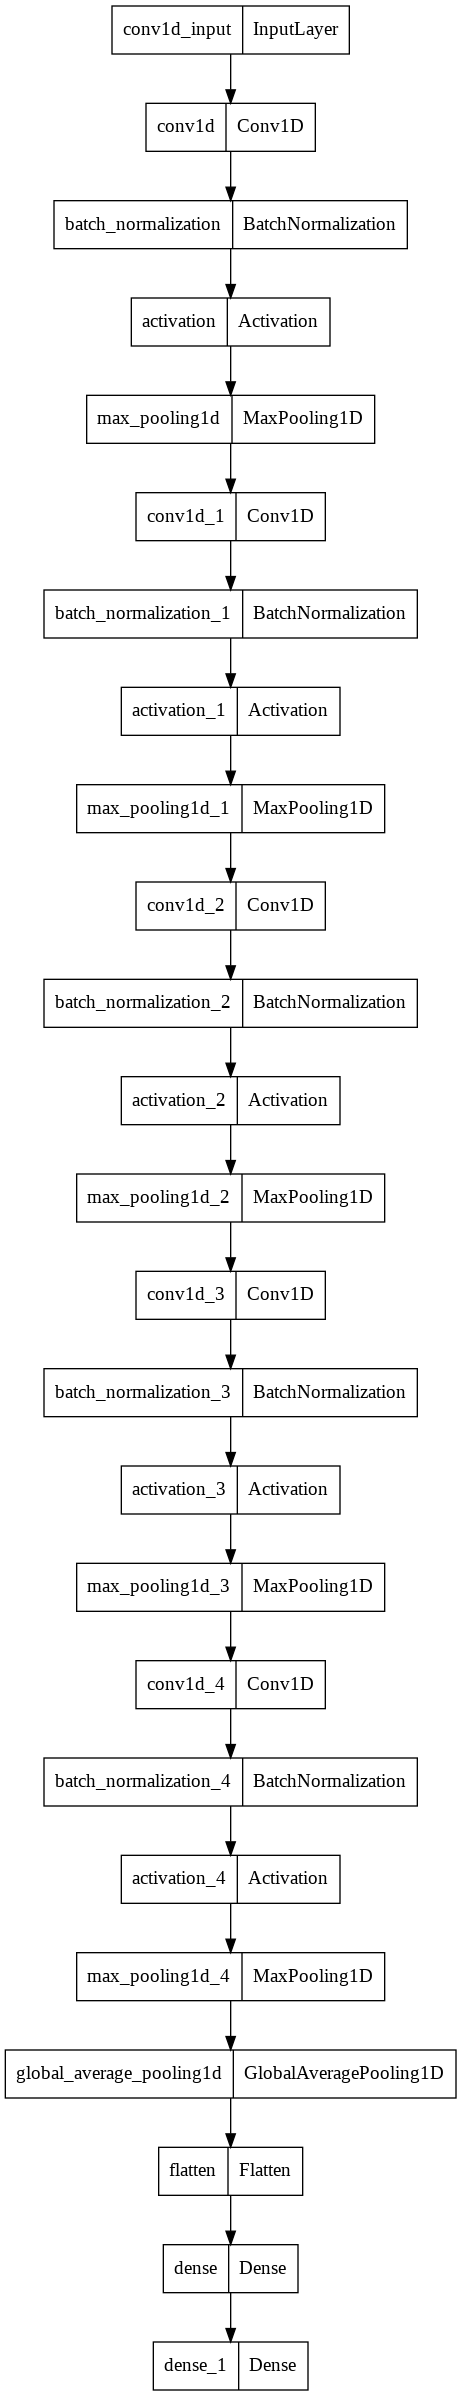

In [ ]:
plot_model(cnn_a_model)

In [ ]:
batchsize = 32
cnn_a_model.fit(X_train, Y_train, batch_size=batchsize, epochs=20, verbose='auto', callbacks=[reduce_lr,early_stop], validation_split=0.1)

Epoch 1/20


Text(0, 0.5, 'Accuracy')

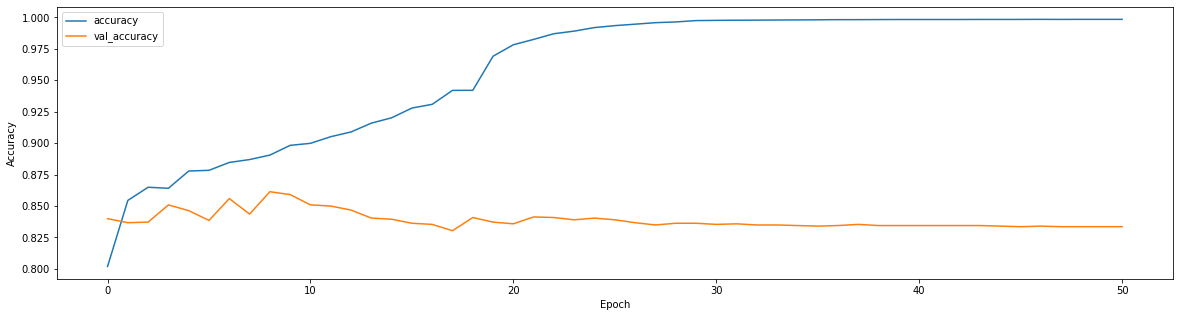

In [ ]:
# plt.plot(cnn_a_model.history.history['accuracy'])
# # plt.plot(lenet_5_model.history.history['Precision'])
# plt.plot(cnn_a_model.history.history['val_accuracy'])
# # plt.plot(lenet_5_model.history.history['val_Precision'])
# plt.legend(("accuracy","val_accuracy"))
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

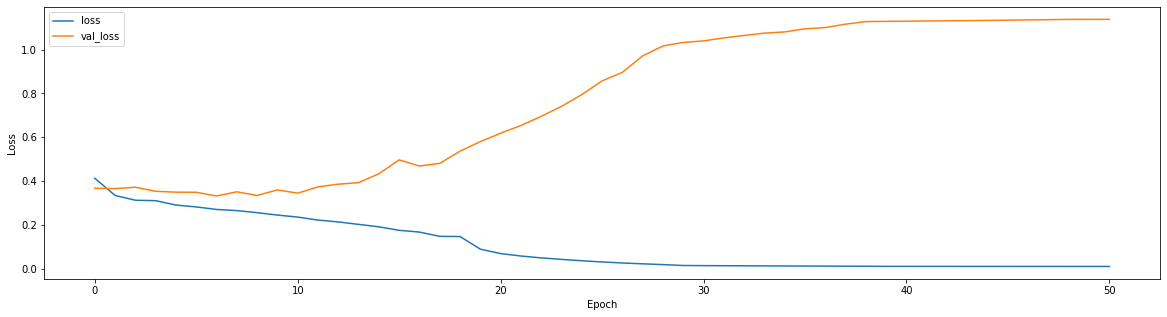

In [ ]:
# plt.plot(cnn_a_model.history.history['loss'])
# plt.plot(cnn_a_model.history.history['val_loss'])
# plt.legend(("loss","val_loss"))
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

In [ ]:
score = cnn_a_model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
y_pred1=cnn_a_model.predict(X_test)
predict1=np.argmax(y_pred1, axis=1)
y_test1=np.argmax(Y_test, axis=1)
conf_mat = confusion_matrix(y_test1, predict1)
print(conf_mat)

  # acc_score=accuracy_score(Y_test,y_pred1)
prec_score = precision_score(y_test1, predict1,average='macro')
rec_score = recall_score(y_test1, predict1,average='macro')
f_score = f1_score(y_test1, predict1,average='macro')
print("Precision(test)= ", prec_score, " Recall(test)= ", rec_score, " F1 Score(test)= ", f_score)


Test loss: 0.3002035319805145 / Test accuracy: 0.8800366520881653


In [ ]:
y_pred=cnn_a_model.predict(X_test)
predict_a=[int (x+0.5) for x in y_pred]
vot.append(np.array(predict_a))
conf_mat=confusion_matrix(Y_test,predict_a)
print(conf_mat)

In [ ]:
accuracy_score(Y_test,predict_a)

0.8357753357753358

**CNN B**

In [ ]:
cnn_b_model=Sequential()

cnn_b_model.add(Conv1D(filters=6, kernel_size=31,padding='same',input_shape=(1000,12)))
cnn_b_model.add(BatchNormalization())
cnn_b_model.add(Activation('relu'))
cnn_b_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

cnn_b_model.add(Conv1D(filters=6, kernel_size=29,padding='same'))
cnn_b_model.add(BatchNormalization())
cnn_b_model.add(Activation('relu'))
cnn_b_model.add(MaxPool1D(pool_size=2,strides=2, padding='same'))

cnn_b_model.add(Conv1D(filters=8, kernel_size=17,padding='same'))
cnn_b_model.add(BatchNormalization())
cnn_b_model.add(Activation('relu'))
cnn_b_model.add(MaxPool1D(pool_size=2,strides=2, padding='same'))

cnn_b_model.add(Conv1D(filters=10,kernel_size=5,padding='same'))
cnn_b_model.add(BatchNormalization())
cnn_b_model.add(Activation('relu'))
cnn_b_model.add(MaxPool1D(pool_size=3,strides=2, padding='same'))


cnn_b_model.add(Conv1D(filters=10, kernel_size=5,padding='same'))
cnn_b_model.add(BatchNormalization())
cnn_b_model.add(Activation('relu'))
cnn_b_model.add(MaxPool1D(pool_size=3,strides=2, padding='same'))


cnn_b_model.add(Conv1D(filters=10, kernel_size=3,padding='same'))
cnn_b_model.add(BatchNormalization())
cnn_b_model.add(Activation('relu'))
cnn_b_model.add(MaxPool1D(pool_size=3,strides=2, padding='same'))


cnn_b_model.add(GlobalAveragePooling1D())

cnn_b_model.add(Flatten(data_format=None))

cnn_b_model.add(Dense(10, activation='relu'))

cnn_b_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
cnn_b_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
cnn_b_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 1000, 6)           2238      
                                                                 
 batch_normalization_5 (Batc  (None, 1000, 6)          24        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 1000, 6)           0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 500, 6)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 500, 6)            1050      
                                                                 
 batch_normalization_6 (Batc  (None, 500, 6)          

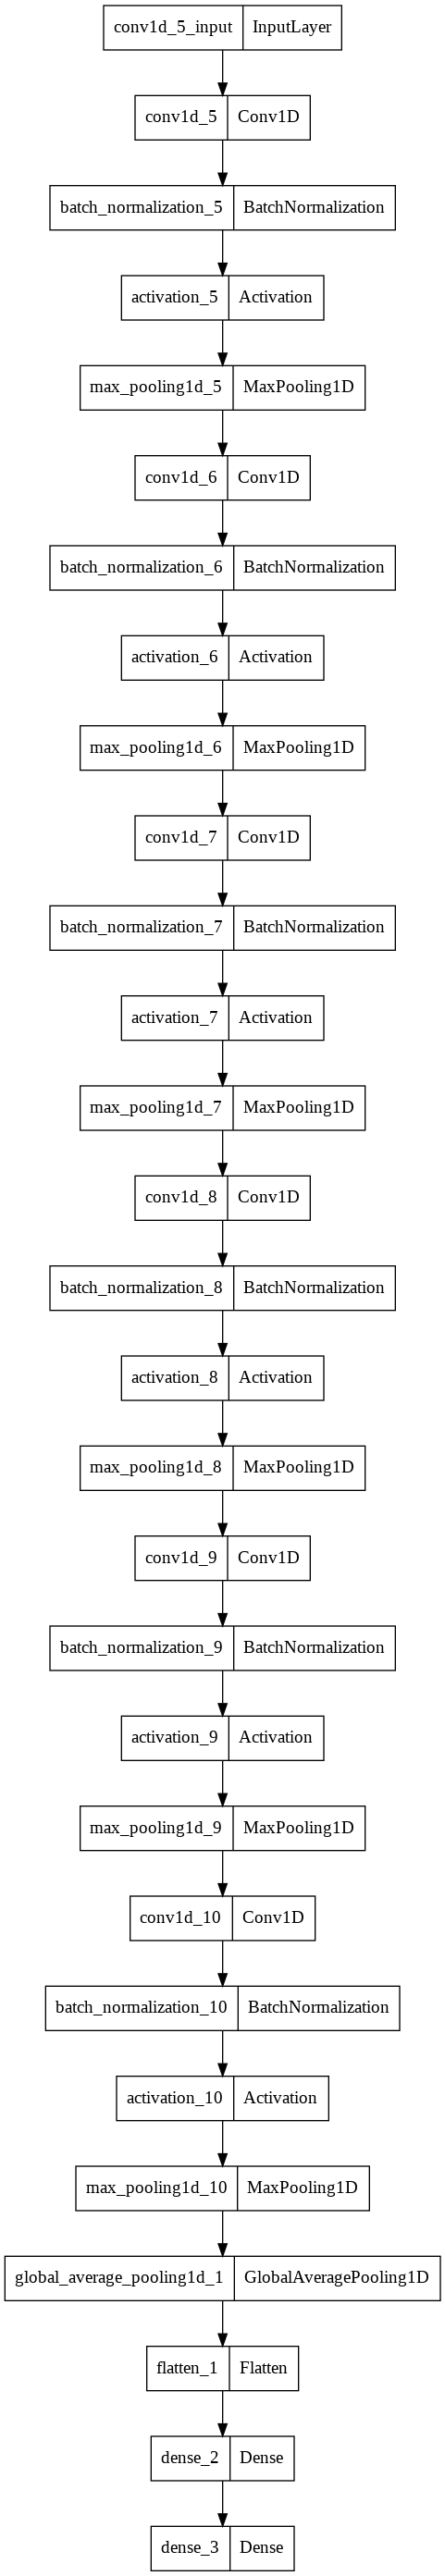

In [ ]:
plot_model(cnn_b_model)

In [ ]:
batchsize = 32
cnn_b_model.fit(X_train, Y_train, batch_size=batchsize, epochs=20, verbose='auto', callbacks=[reduce_lr,early_stop], validation_split=0.1)

Epoch 1/150
546/546 [==============================] - 5s 8ms/step - loss: 0.4465 - accuracy: 0.7832 - val_loss: 0.3693 - val_accuracy: 0.8418 - lr: 0.0010
Epoch 2/150
546/546 [==============================] - 4s 7ms/step - loss: 0.3521 - accuracy: 0.8465 - val_loss: 0.3625 - val_accuracy: 0.8358 - lr: 0.0010
Epoch 3/150
546/546 [==============================] - 4s 7ms/step - loss: 0.3353 - accuracy: 0.8535 - val_loss: 0.3560 - val_accuracy: 0.8427 - lr: 0.0010
Epoch 4/150
546/546 [==============================] - 4s 7ms/step - loss: 0.3248 - accuracy: 0.8604 - val_loss: 0.3615 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 5/150
546/546 [==============================] - 4s 7ms/step - loss: 0.3190 - accuracy: 0.8616 - val_loss: 0.3531 - val_accuracy: 0.8450 - lr: 0.0010
Epoch 6/150
546/546 [==============================] - 4s 7ms/step - loss: 0.3066 - accuracy: 0.8667 - val_loss: 0.3467 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 7/150
546/546 [==============================] - 4s 7ms/st

Text(0, 0.5, 'Accuracy')

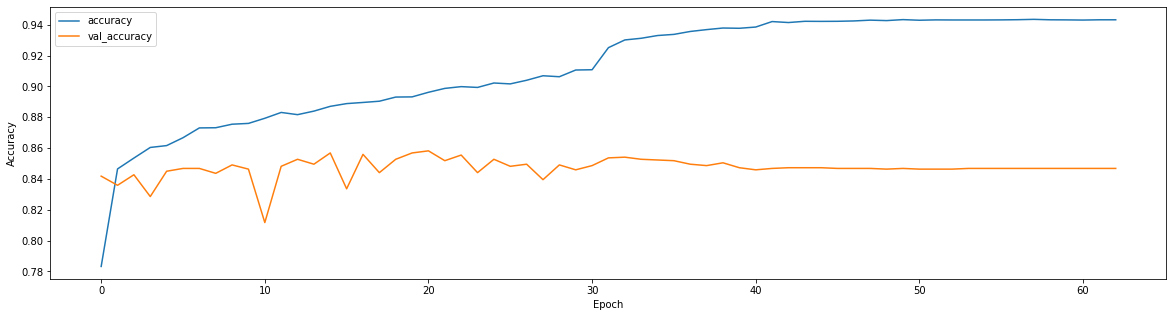

In [ ]:
# plt.plot(cnn_b_model.history.history['accuracy'])
# # plt.plot(lenet_5_model.history.history['Precision'])
# plt.plot(cnn_b_model.history.history['val_accuracy'])
# # plt.plot(lenet_5_model.history.history['val_Precision'])
# plt.legend(("accuracy","val_accuracy"))
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

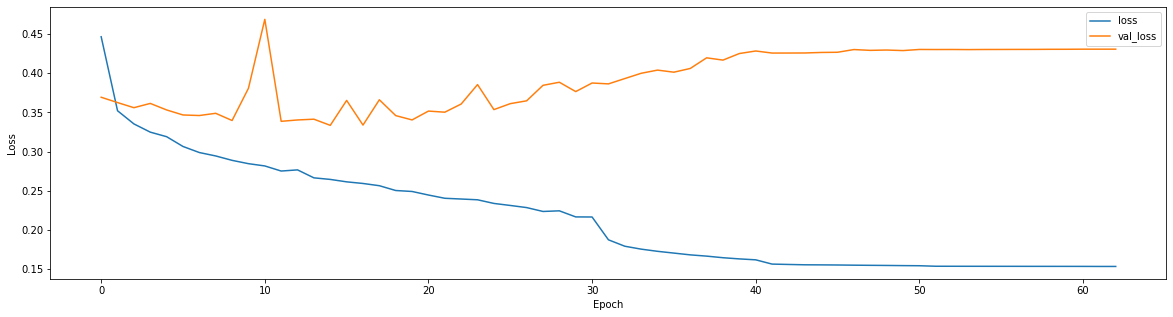

In [ ]:
# plt.plot(cnn_b_model.history.history['loss'])
# # plt.plot(cnn_b_model.history.history['val_loss'])
# plt.legend(("loss","val_loss"))
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

In [ ]:
y_pred=cnn_b_model.predict(test_signal)
predict_b=[int (x+0.5) for x in y_pred]
vot.append(np.array(predict_b))
conf_mat=confusion_matrix(test_bclass,predict_b)
print(conf_mat)

[[1007  232]
 [ 119  845]]


In [ ]:
accuracy_score(test_bclass,predict_b)

0.8406718111665911

**CNN C**

In [ ]:
cnn_c_model=Sequential()

cnn_c_model.add(Conv1D(filters=5, kernel_size=29,padding='same',input_shape=(1000,12)))
cnn_c_model.add(BatchNormalization())
cnn_c_model.add(Activation('relu'))
cnn_c_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

cnn_c_model.add(Conv1D(filters=5, kernel_size=15,padding='same'))
cnn_c_model.add(BatchNormalization())
cnn_c_model.add(Activation('relu'))
cnn_c_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

cnn_c_model.add(Conv1D(filters=5, kernel_size=13, padding='same'))
cnn_c_model.add(BatchNormalization())
cnn_c_model.add(Activation('relu'))
cnn_c_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

cnn_c_model.add(Conv1D(filters=10, kernel_size=5, padding='same'))
cnn_c_model.add(BatchNormalization())
cnn_c_model.add(Activation('relu'))
cnn_c_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

cnn_c_model.add(Conv1D(filters=10, kernel_size=4, padding='same'))
cnn_c_model.add(BatchNormalization())
cnn_c_model.add(Activation('relu'))
cnn_c_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

cnn_c_model.add(Conv1D(filters=10, kernel_size=4, padding='same'))
cnn_c_model.add(BatchNormalization())
cnn_c_model.add(Activation('relu'))
cnn_c_model.add(MaxPool1D(pool_size=3, strides=2, padding='same'))

cnn_c_model.add(Conv1D(filters=10,  kernel_size=3, padding='same'))
cnn_c_model.add(BatchNormalization())
cnn_c_model.add(Activation('relu'))
cnn_c_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))


cnn_c_model.add(GlobalAveragePooling1D())

cnn_c_model.add(Flatten(data_format=None))

cnn_c_model.add(Dense(10, activation='relu'))

cnn_c_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
cnn_c_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
cnn_c_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 1000, 5)           1745      
                                                                 
 batch_normalization_11 (Bat  (None, 1000, 5)          20        
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 1000, 5)           0         
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 500, 5)           0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 500, 5)            380       
                                                                 
 batch_normalization_12 (Bat  (None, 500, 5)          

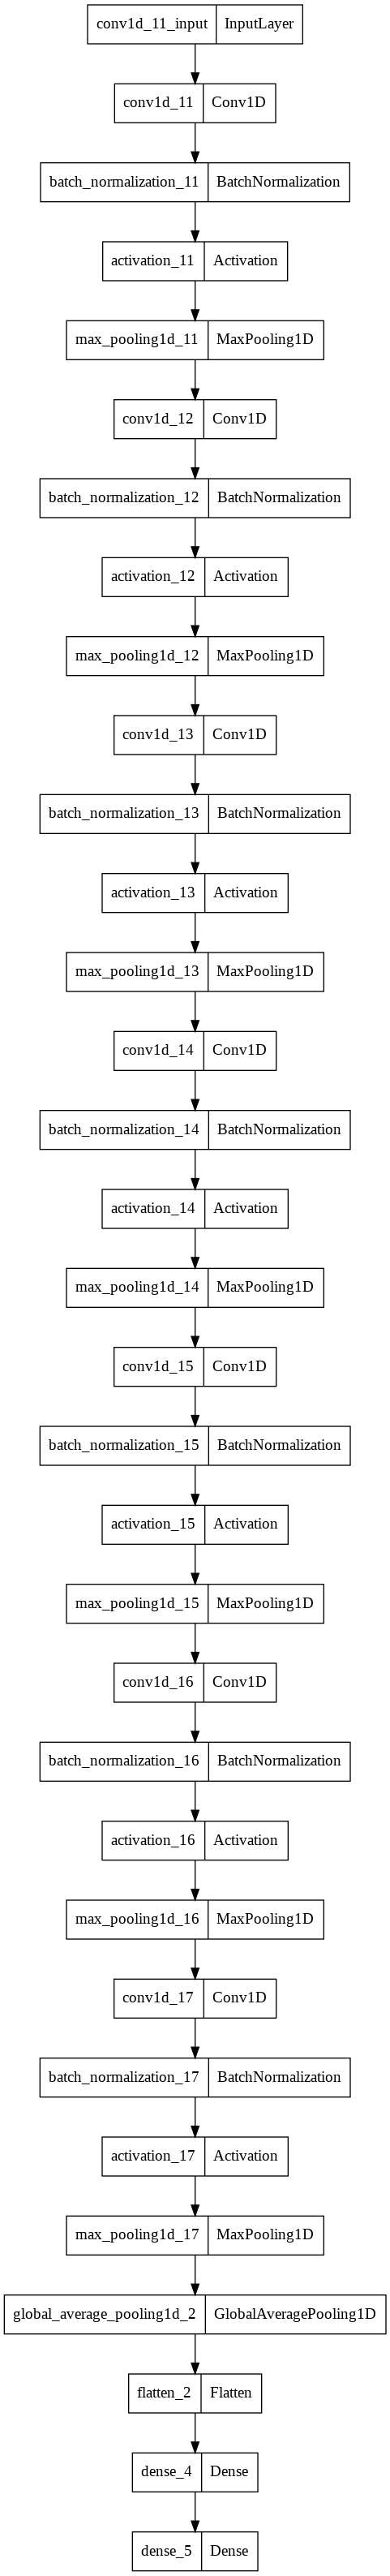

In [ ]:
plot_model(cnn_c_model)

In [ ]:
batchsize = 32
cnn_c_model.fit(X_train, Y_train, batch_size=batchsize, epochs=20, verbose='auto', callbacks=[reduce_lr,early_stop], validation_split=0.1)

Epoch 1/20
546/546 [==============================] - 25s 15ms/step - loss: 0.4022 - accuracy: 0.8223 - val_loss: 0.3468 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 2/20
546/546 [==============================] - 7s 13ms/step - loss: 0.3272 - accuracy: 0.8565 - val_loss: 0.3334 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 3/20
546/546 [==============================] - 8s 15ms/step - loss: 0.3133 - accuracy: 0.8640 - val_loss: 0.3244 - val_accuracy: 0.8532 - lr: 0.0010
Epoch 4/20
546/546 [==============================] - 7s 13ms/step - loss: 0.3031 - accuracy: 0.8704 - val_loss: 0.3290 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 5/20
546/546 [==============================] - 7s 13ms/step - loss: 0.2981 - accuracy: 0.8693 - val_loss: 0.3652 - val_accuracy: 0.8395 - lr: 0.0010
Epoch 6/20
546/546 [==============================] - 7s 13ms/step - loss: 0.2932 - accuracy: 0.8720 - val_loss: 0.3331 - val_accuracy: 0.8632 - lr: 0.0010
Epoch 7/20
546/546 [==============================] - 7s 13ms/s

Text(0, 0.5, 'Accuracy')

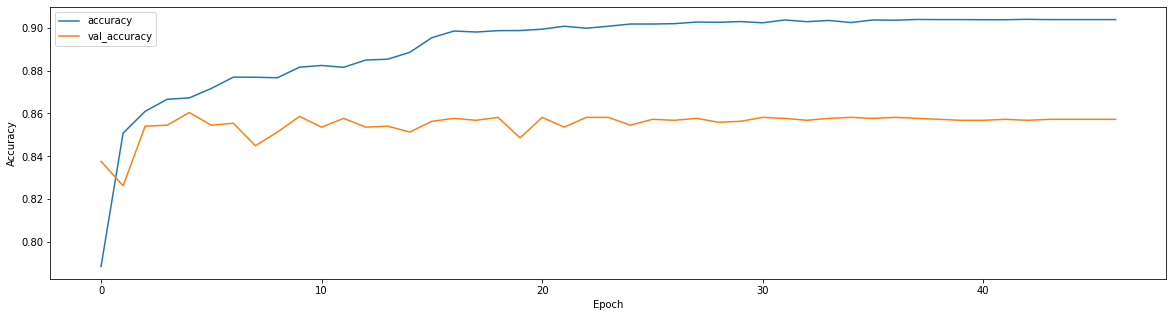

In [ ]:
# plt.plot(cnn_c_model.history.history['accuracy'])
# # plt.plot(lenet_5_model.history.history['Precision'])
# plt.plot(cnn_c_model.history.history['val_accuracy'])
# # plt.plot(lenet_5_model.history.history['val_Precision'])
# plt.legend(("accuracy","val_accuracy"))
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

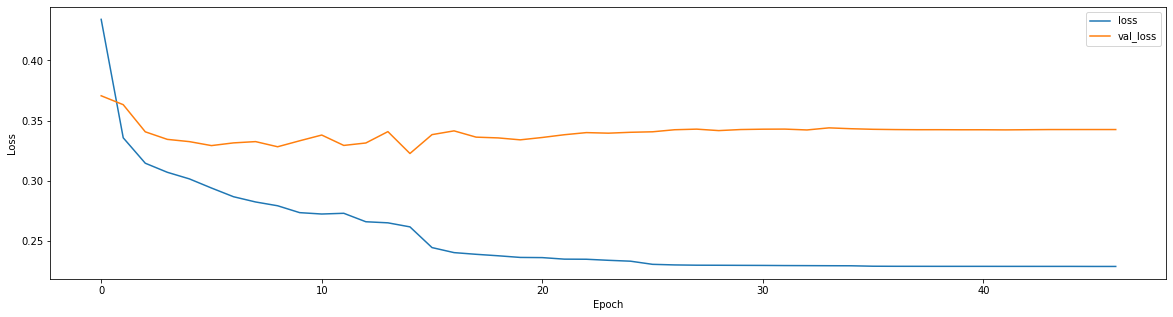

In [ ]:
# plt.plot(cnn_c_model.history.history['loss'])
# plt.plot(cnn_c_model.history.history['val_loss'])
# plt.legend(("loss","val_loss"))
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

In [ ]:
score = cnn_c_model.evaluate(X_test, Y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.24375976622104645 / Test accuracy: 0.89682537317276


In [ ]:
y_pred=cnn_c_model.predict(test_signal)
predict_c=[int (x+0.5) for x in y_pred]
vot.append(np.array(predict_c))
conf_mat=confusion_matrix(test_bclass,predict_c)
print(conf_mat)

69/69 [==============================] - 1s 5ms/step
[[1015  224]
 [  91  873]]


In [ ]:
accuracy_score(test_bclass,predict_c)

0.8570131638674535

In [ ]:
y_prob = np.array(vot).transpose()


In [ ]:
y_prob.shape

(2203, 3)

In [ ]:
import collections

In [ ]:
final_out=[]
for i in range(0, y_prob.shape[0]):
  a=np.array(y_prob[i,:])
  a= collections.Counter(a).most_common()[0][0]
  final_out.append(a)

In [ ]:
print(classification_report(test_bclass,final_out))

'              precision    recall  f1-score   support\n\n           0       0.91      0.83      0.87      1239\n           1       0.80      0.90      0.85       964\n\n    accuracy                           0.86      2203\n   macro avg       0.86      0.86      0.86      2203\nweighted avg       0.86      0.86      0.86      2203\n'

**CNN MODEL**

**Lenet-5 model**

In [ ]:
lenet_5_model=Sequential()

lenet_5_model.add(Conv1D(filters=6, kernel_size=3, padding='same', input_shape=(1000,12)))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(Conv1D(filters=16, strides=1, kernel_size=5))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(GlobalAveragePooling1D())

lenet_5_model.add(Dense(64, activation='relu'))

lenet_5_model.add(Dense(32, activation='relu'))

lenet_5_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# lenet_5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
lenet_5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# lenet_5_model.summary()

In [ ]:
# plot_model(lenet_5_model)

In [ ]:
batchsize = 32
lenet_5_model.fit(x=signal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=[reduce_lr,early_stop], validation_data=(v_signal,v_target))

In [ ]:
plt.plot(lenet_5_model.history.history['accuracy'])
# plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['val_accuracy'])
# plt.plot(lenet_5_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(lenet_5_model.history.history['loss'])
plt.plot(lenet_5_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(lenet_5_model.history.history['Recall'])
# plt.plot(lenet_5_model.history.history['Precision'])
# plt.plot(lenet_5_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y_pred=lenet_5_model.predict(test_signal)
predict=[int (x+0.5) for x in y_pred]
conf_mat=confusion_matrix(test_bclass,predict)
print(conf_mat)

In [ ]:
accuracy_score(test_bclass,predict)

**AlexNet model**

In [ ]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(1000,12)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(GlobalAveragePooling1D())
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# alexNet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
alexNet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# alexNet_model.summary()

In [ ]:
# plot_model(alexNet_model)

In [ ]:
batchsize = 32
alexNet_model.fit(x=signal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

In [ ]:
plt.plot(alexNet_model.history.history['accuracy'])
# plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['val_accuracy'])
# plt.plot(alexNet_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(alexNet_model.history.history['loss'])
plt.plot(alexNet_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(alexNet_model.history.history['Recall'])
# plt.plot(alexNet_model.history.history['Precision'])
# plt.plot(alexNet_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y_pred=alexNet_model.predict(test_signal)
predict=[int(x+0.5) for x in y_pred]
conf_mat=confusion_matrix(test_bclass,predict)
print(conf_mat)

In [ ]:
accuracy_score(test_bclass,predict)

**VGG 16**

In [ ]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same',  input_shape=(1000,12)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(GlobalAveragePooling1D())
vgg_16_model.add(Dense(256, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(128, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(1, activation='sigmoid'))

In [ ]:
#  vgg_16_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
vgg_16_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# vgg_16_model.summary()

In [ ]:
# plot_model(vgg_16_model)

In [ ]:
batchsize = 32
vgg_16_model.fit(x=signal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

In [ ]:
plt.plot(vgg_16_model.history.history['accuracy'])
# plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['val_accuracy'])
# plt.plot(vgg_16_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(vgg_16_model.history.history['loss'])
plt.plot(vgg_16_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(vgg_16_model.history.history['Recall'])
# plt.plot(vgg_16_model.history.history['Precision'])
# plt.plot(vgg_16_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y_pred=vgg_16_model.predict(test_signal)
predict=[int(x+0.5) for x in y_pred]
conf_mat=confusion_matrix(test_bclass,predict)
print(conf_mat)

In [ ]:
accuracy_score(test_bclass,predict)

**Resnet 50 Model**

In [ ]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape):
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
resNet50_model = ResNet50(input_shape = (1000,12))

In [ ]:
# resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# resNet50_model.summary()

In [ ]:
# plot_model(resNet50_model)

In [ ]:
batchsize = 32
resNet50_model.fit(x=signal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

In [ ]:
plt.plot(resNet50_model.history.history['accuracy'])
# plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['val_accuracy'])
# plt.plot(resNet50_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(resNet50_model.history.history['loss'])
plt.plot(resNet50_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(resNet50_model.history.history['Recall'])
# plt.plot(resNet50_model.history.history['Precision'])
# plt.plot(resNet50_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y_pred=resNet50_model.predict(test_signal)
predict=[int(x+0.5) for x in y_pred]
conf_mat=confusion_matrix(test_bclass,predict)
print(conf_mat)

In [ ]:
accuracy_score(test_bclass,predict)

**Inseption Model**

In [ ]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [ ]:
inception_model = inception_model(input_shape = (1000,12))

In [ ]:
# inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# inception_model.summary()

In [ ]:
# plot_model(inception_model)

In [ ]:
batchsize = 32
inception_model.fit(x=signal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

In [ ]:
plt.plot(inception_model.history.history['accuracy'])
# plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['val_accuracy'])
# plt.plot(inception_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(inception_model.history.history['loss'])
plt.plot(inception_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(inception_model.history.history['Recall'])
# plt.plot(inception_model.history.history['Precision'])
# plt.plot(inception_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
y_pred=inception_model.predict(test_signal)
predict=[int(x+0.5) for x in y_pred]
conf_mat=confusion_matrix(test_bclass,predict)
print(conf_mat)

In [ ]:
accuracy_score(test_bclass,predict)

**RNN Models**

**LSTM Model**

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1000,12), return_sequences=True, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(64))



lstm_model.add(Dense(16, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
#  lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# lstm_model.summary()

In [ ]:
# plot_model(lstm_model)

In [ ]:
batchsize = 32
lstm_model.fit(x=signal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

In [ ]:
plt.plot(lstm_model.history.history['accuracy'])
# plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
# plt.plot(lstm_model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# plt.plot(lstm_model.history.history['Recall'])
# plt.plot(lstm_model.history.history['Precision'])
# plt.plot(lstm_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
#ann_model = Sequential()
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(GlobalAveragePooling1D())
#ann_model.add(Dense(1, activation='sigmoid'))

In [ ]:
y_pred=lstm_model.predict(test_signal)
predict=[int(x+0.5) for x in y_pred]
conf_mat=confusion_matrix(test_bclass,predict)
print(conf_mat)

In [ ]:
accuracy_score(test_bclass,predict)

**CNN+LSTM**

In [ ]:
# convlstm_model = Sequential()
# convlstm_model.add(Input((10,100,12)))
# convlstm_model.add(ConvLSTM1D(64, kernel_size=2, strides=1, padding = 'same',return_sequences=True))
# convlstm_model.add(BatchNormalization())

# convlstm_model.add(ConvLSTM1D(64,padding = 'same', kernel_size=3))
# convlstm_model.add(Dense(32, activation = 'relu'))
# convlstm_model.add(Dropout(0.3))
# convlstm_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# convlstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
# convlstm_model.summary()

In [ ]:
# plot_model(convlstm_model)

In [ ]:
# batchsize = 32
# convlstm_model.fit(x=newsignal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(newv_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

In [ ]:
# plt.plot(convlstm_model.history.history['accuracy'])
# plt.plot(convlstm_model.history.history['Precision'])
# plt.plot(convlstm_model.history.history['val_accuracy'])
# plt.plot(convlstm_model.history.history['val_Precision'])
# plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

In [ ]:
# plt.plot(convlstm_model.history.history['loss'])
# plt.plot(convlstm_model.history.history['val_loss'])
# plt.legend(("loss","val_loss"))
# plt.xlabel('Epoch')
# plt.ylabel('Loss')

In [ ]:
# plt.plot(convlstm_model.history.history['Recall'])
# plt.plot(convlstm_model.history.history['Precision'])
# plt.plot(convlstm_model.history.history['AUC'])
# plt.legend(("Recall","Precision","AUC"))
# plt.xlabel('Epoch')

In [ ]:
input_layer = Input(shape=(1000,12))
conv1 = Conv1D(filters=32,
kernel_size=8,
strides=1,
activation='relu')(input_layer)
pool1 = MaxPool1D(pool_size=4)(conv1)
lstm1 = LSTM(64)(pool1)
output_layer = Dense(1, activation='sigmoid')(lstm1)
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
#         name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
#                     tf.keras.metrics.AUC(
#         num_thresholds=200,
#         curve="ROC",
#         summation_method="interpolation",
#         name="AUC",
#         dtype=None,
#         thresholds=None,
#         multi_label=True,
#         label_weights=None,
#     )])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy','AUC'])

In [ ]:
# model.summary()

In [ ]:
# plot_model(model)

In [ ]:
#tf.config.run_functions_eagerly(True)

In [ ]:
batchsize = 32
model.fit(x=signal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=[reduce_lr,early_stop],  validation_data=(v_signal,v_target))

In [ ]:
plt.plot(model.history.history['accuracy'])
#plt.plot(model.history.history['Precision'])
plt.plot(model.history.history['val_accuracy'])
#plt.plot(model.history.history['val_Precision'])
plt.legend(("accuracy","val_accuracy"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
y_pred=model.predict(test_signal)
predict=[int(x+0.5) for x in y_pred]
conf_mat=confusion_matrix(test_bclass,predict)
print(conf_mat)

In [ ]:
accuracy_score(test_bclass,predict)